In [1]:
import gc
import os
import sys
import warnings
from glob import glob

import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import torch.nn as nn
import torch.nn.functional as F
from segmentation_models_pytorch.decoders.unet.decoder import DecoderBlock
from timm.models.resnet import resnet10t, resnet34d
from torch.cuda import amp
from tqdm import tqdm
from einops import rearrange


In [2]:
sys.path.append('/kaggle/working/notebook/experiment/stacked_unet')
from script.metrics import *
from script.dataset import *
from script.helper import *
from script.scheduler import *
from script.loss import *

### Config

In [3]:
class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'
    comp_dir_path = '/kaggle/input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'

    dataset_path = "/kaggle/working/dataset_train/"
    train_dataset_path = "/kaggle/working/dataset_train/nonflatten/25-37/"
    dataset_range = train_dataset_path.split("/")[-2]

    exp_name = os.getcwd().split('/')[-1]

    # ============== model cfg =============

    z_start = int(train_dataset_path.rstrip("/").split("/")[-1].split("-")[0])
    z_end = int(train_dataset_path.rstrip("/").split("/")[-1].split("-")[1])
    in_chans = z_end-z_start+1
    crop_depth = 6
    random_shift = random.randint(0, 4)
    layer_shift = [0,2,4,6]
    
    # ============== training cfg =============
    size = 256
    tile_size = 256
    stride = tile_size //2

    train_batch_size = 64  # 32
    valid_batch_size = train_batch_size

    epochs = 25  # 15

    lr = 1e-4
    loss = "bce_dice_loss"


    # ============== fixed =============
    num_workers = 4
    seed = 42

    # ============== augmentation =============
    train_aug_list = [
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(),
        A.ShiftScaleRotate(p=0.5),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3),
                        mask_fill_value=0, p=0.5),
        A.Normalize(
            mean=[0] * in_chans,
            std=[1] * in_chans,
            max_pixel_value=65535,
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean=[0] * in_chans,
            std=[1] * in_chans,
            max_pixel_value=65535,
        ),
        ToTensorV2(transpose_mask=True),
    ]


warnings.filterwarnings("ignore")
torch.backends.cudnn.benchmark = True  # type: ignore

set_seed(CFG.seed)
os.makedirs(f'./{CFG.exp_name}/', exist_ok=True)


### Load data

In [4]:
def preprocess(image, fragment_i, split_i):
    return image



len(train_images) = 11194
train_images[0].shape = (256, 256, 13)
train_labels[0].shape = (256, 256, 1)
train_masks[0].shape = (256, 256, 1)

len(valid_images) = 3087
valid_images[0].shape = (256, 256, 13)
valid_labels[0].shape = (256, 256, 1)



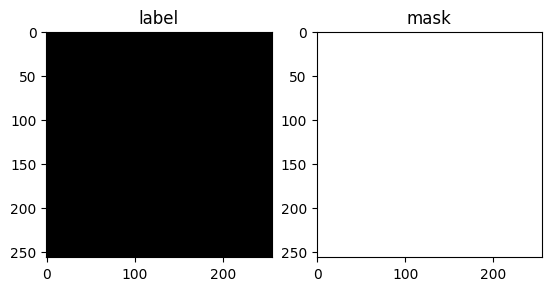

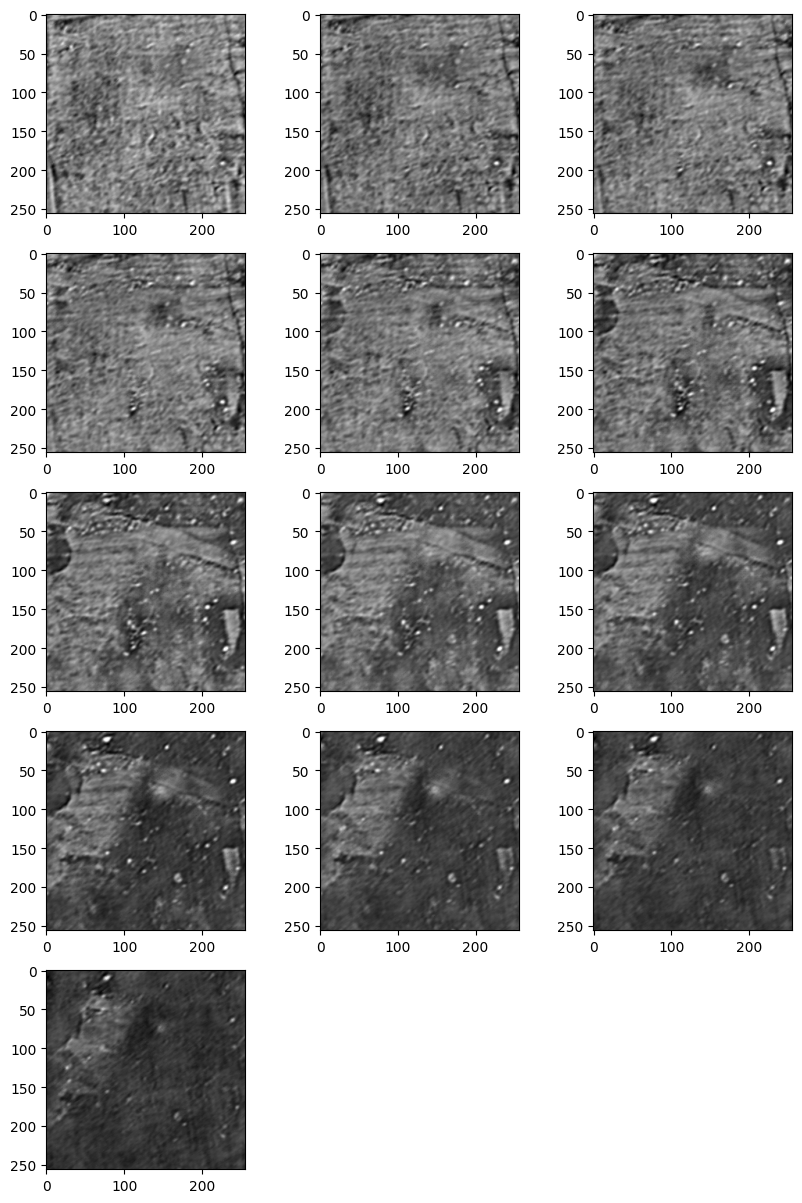

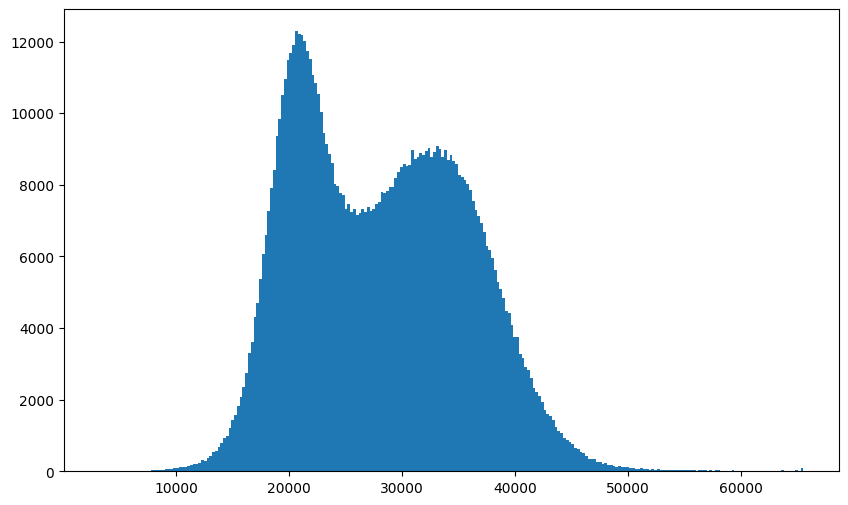

In [5]:
# confirmation

valid_fragment_i = 1
valid_split_i = 0

train_images, train_labels, train_masks, valid_images, valid_labels, valid_xyxys = get_train_valid_dataset(valid_fragment_i, valid_split_i, CFG, preprocess)

print(f"""
{len(train_images) = }
{train_images[0].shape = }
{train_labels[0].shape = }
{train_masks[0].shape = }

{len(valid_images) = }
{valid_images[0].shape = }
{valid_labels[0].shape = }
""")

id = random.randint(0, len(train_labels))
visualize_train_images(id, train_images, train_labels, train_masks)


### Model

In [6]:
class SmpUnetDecoder(nn.Module):
	def __init__(self,
	         in_channel,
	         skip_channel,
	         out_channel,
	    ):
		super().__init__()
		self.center = nn.Identity()

		i_channel = [in_channel,]+ out_channel[:-1]
		s_channel = skip_channel
		o_channel = out_channel
		block = [
			DecoderBlock(i, s, o, use_batchnorm=True, attention_type=None)
			for i, s, o in zip(i_channel, s_channel, o_channel)
		]
		self.block = nn.ModuleList(block)

	def forward(self, feature, skip):
		d = self.center(feature)
		decode = []
		for i, block in enumerate(self.block):
			s = skip[i]
			d = block(d, s)
			decode.append(d)

		last  = d
		return last, decode

class Net(nn.Module):
	def __init__(self,):
		super().__init__()
		self.output_type = ['inference', 'loss']

		conv_dim = 64
		encoder1_dim  = [conv_dim, 64, 128, 256, 512, ]
		decoder1_dim  = [256, 128, 64, 64,]

		self.encoder1 = resnet34d(pretrained=True, in_chans=CFG.crop_depth)

		self.decoder1 = SmpUnetDecoder(
			in_channel   = encoder1_dim[-1],
			skip_channel = encoder1_dim[:-1][::-1],
			out_channel  = decoder1_dim,
		)
		# -- pool attention weight
		self.weight1 = nn.ModuleList([
			nn.Sequential(
				nn.Conv2d(dim, dim, kernel_size=3, padding=1),
				nn.ReLU(inplace=True),
			) for dim in encoder1_dim
		])
		self.logit1 = nn.Conv2d(decoder1_dim[-1],1,kernel_size=1)

		#--------------------------------
		#
		encoder2_dim  = [64, 128, 256, 512]
		decoder2_dim  = [128, 64, 32, ]
		self.encoder2 = resnet10t(pretrained=True, in_chans=decoder1_dim[-1])
		

		self.decoder2 = SmpUnetDecoder(
			in_channel   = encoder2_dim[-1],
			skip_channel = encoder2_dim[:-1][::-1],
			out_channel  = decoder2_dim,
		)
		self.logit2 = nn.Conv2d(decoder2_dim[-1],1,kernel_size=1)

	def forward(self, batch):
		v = batch
		B,C,H,W = v.shape
		random_shift = CFG.random_shift
		vv = [
            v[:, i+random_shift:i+random_shift+CFG.crop_depth] for i in CFG.layer_shift
		]
		K = len(vv)
		x = torch.cat(vv,0)
		#x = v

		#----------------------
		encoder = []
		e = self.encoder1
		x = e.conv1(x)
		x = e.bn1(x)
		x = e.act1(x);
		encoder.append(x)
		x = F.avg_pool2d(x, kernel_size=2, stride=2)
		x = e.layer1(x);
		encoder.append(x)
		x = e.layer2(x);
		encoder.append(x)
		x = e.layer3(x);
		encoder.append(x)
		x = e.layer4(x);
		encoder.append(x)
		# print('encoder', [f.shape for f in encoder])

		for i in range(len(encoder)):
			e = encoder[i]
			f = self.weight1[i](e)
			_, c, h, w = e.shape
			f = rearrange(f, '(K B) c h w -> B K c h w', K=K, B=B, h=h, w=w)  #
			e = rearrange(e, '(K B) c h w -> B K c h w', K=K, B=B, h=h, w=w)  #
			w = F.softmax(f, 1)
			e = (w * e).sum(1)
			encoder[i] = e

		feature = encoder[-1]
		skip = encoder[:-1][::-1]
		last, decoder = self.decoder1(feature, skip)
		logit1 = self.logit1(last)

		#----------------------
		x = last #.detach()
		#x = F.avg_pool2d(x,kernel_size=2,stride=2)
		encoder = []
		e = self.encoder2
		x = e.layer1(x); encoder.append(x)
		x = e.layer2(x); encoder.append(x)
		x = e.layer3(x); encoder.append(x)
		x = e.layer4(x); encoder.append(x)

		feature = encoder[-1]
		skip = encoder[:-1][::-1]
		last, decoder = self.decoder2(feature, skip)
		logit2 = self.logit2(last)
		logit1 = F.interpolate(logit1, size=(H
                                       , W), mode='bilinear', align_corners=False, antialias=True)
		logit2 = F.interpolate(logit2, size=(H
                                       , W), mode='bilinear', align_corners=False, antialias=True)

		return logit1, logit2


### Training

In [7]:
for fold_i, fold in enumerate(glob(f"{CFG.train_dataset_path}/*")):
    fold = os.path.basename(fold).split(".")[0]
    valid_fragment_i = int(fold.split("_")[0])
    valid_split_i = int(fold.split("_")[1])
    print(f"fold: {fold_i}")

    train_images, train_labels, train_masks, valid_images, valid_labels, valid_xyxys = get_train_valid_dataset(valid_fragment_i, valid_split_i, CFG, preprocess, "inklabels")

    dataloader_train, dataloader_valid = generate_dataloader(train_images, train_labels,  valid_images, valid_labels, valid_xyxys, CFG)

    n_train = len(dataloader_train)
    n_valid = len(dataloader_valid)

    gt_mask = generate_valid_label(valid_fragment_i, valid_split_i, CFG, "inklabels")
    gt_shape = gt_mask.shape


    num_gpus = torch.cuda.device_count()
    device_ids = list(range(num_gpus))

    model = Net()
    model = nn.DataParallel(model, device_ids=device_ids)
    model = model.cuda()

    scaler = amp.GradScaler()
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr)
    scheduler = get_scheduler(CFG, optimizer)

    fbeta = 0

    for epoch in range(CFG.epochs):
        model.train()
        cur_lr = f"LR : {scheduler.get_last_lr()[0]:.2E}"
        pbar_train = enumerate(dataloader_train)
        pbar_train = tqdm(pbar_train, total=n_train, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
        mloss_train, mloss_val = 0.0, 0.0

        for i, (fragments, masks) in pbar_train:
            fragments, masks = fragments.cuda(), masks.cuda()
            optimizer.zero_grad()
            with amp.autocast():  # type: ignore
                logit1, logit2 = model(fragments)
                loss1 = criterion(logit1, masks)
                loss2 = criterion(logit2, masks)
                loss = loss1+loss2
                scaler.scale(loss).backward()# type: ignore
                scaler.step(optimizer)
                scaler.update()
                mloss_train += loss.detach().item()

            gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
            pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{CFG.epochs}", gpu_mem, cur_lr,
                                                                  f"Loss: {mloss_train / (i + 1):.4f}"))

        scheduler.step()
        model.eval()
        pbar_val = enumerate(dataloader_valid)
        pbar_val = tqdm(pbar_val, total=n_valid, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
        final_pred_mask = torch.zeros(gt_shape, dtype=torch.float32, device='cuda')  # type: ignore
        final_pred_count = torch.zeros(gt_shape)

        for i, (fragments, masks, xys) in pbar_val:
            fragments, masks = fragments.cuda(), masks.cuda()
            with torch.no_grad():
                logit1, logit2 = model(fragments)
                loss1 = criterion(logit1, masks)
                loss2 = criterion(logit2, masks)
                loss = loss1+loss2
                mloss_val += loss.detach().item()
                pred_masks = torch.sigmoid(logit2)

            for j, xy in enumerate(xys):
                final_pred_mask[xy[1]:xy[3], xy[0]:xy[2]] += pred_masks[j, 0]
                final_pred_count[xy[1]:xy[3], xy[0]:xy[2]] += np.ones((CFG.size, CFG.size))

            pbar_val.set_description(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))
        final_pred_mask = final_pred_mask.cpu()
        final_pred_mask /= final_pred_count

        fbeta_ = fbeta_score(final_pred_mask, gt_mask, 0.5)
        print(f"FBeta : {fbeta_:.4f}\tSAVED MODEL\n" if fbeta_ > fbeta else f"FBeta : {fbeta_:.4f}\n")
        if fbeta_ > fbeta:
            fbeta = fbeta_
            model_path = f'./{CFG.exp_name}/{CFG.exp_name}_fold{fold_i}.pth'
            torch.save({'model': model.module.state_dict(),
                        'preds': final_pred_mask.numpy()},
                       model_path)

    del model
    gc.collect()
!curl -X POST -H 'Authorization: Bearer '$LINE -F 'message=セルの実行が終わりました！' https://notify-api.line.me/api/notify


fold: 0


Epoch 0/25  Mem : 22.2GB  LR : 1.00E-04  Loss: 0.9704: 100%|██████████| 174/174 
Val Loss: 0.8398: 100%|██████████| 49/49 [00:14<00:00,  3.40it/s]               


FBeta : 0.3669	SAVED MODEL



Epoch 1/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.5881: 100%|██████████| 174/174 
Val Loss: 0.6466: 100%|██████████| 49/49 [00:14<00:00,  3.48it/s]               


FBeta : 0.4207	SAVED MODEL



Epoch 2/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.4801: 100%|██████████| 174/174 
Val Loss: 0.4908: 100%|██████████| 49/49 [00:14<00:00,  3.47it/s]               


FBeta : 0.2600



Epoch 3/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.4505: 100%|██████████| 174/174 
Val Loss: 0.5016: 100%|██████████| 49/49 [00:14<00:00,  3.45it/s]               


FBeta : 0.3697



Epoch 4/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.4273: 100%|██████████| 174/174 
Val Loss: 0.5153: 100%|██████████| 49/49 [00:14<00:00,  3.49it/s]               


FBeta : 0.4508	SAVED MODEL



Epoch 5/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.4089: 100%|██████████| 174/174 
Val Loss: 1.1398: 100%|██████████| 49/49 [00:14<00:00,  3.49it/s]               


FBeta : 0.3192



Epoch 6/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.3980: 100%|██████████| 174/174 
Val Loss: 0.5519: 100%|██████████| 49/49 [00:14<00:00,  3.47it/s]               


FBeta : 0.4499



Epoch 7/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.3817: 100%|██████████| 174/174 
Val Loss: 0.5156: 100%|██████████| 49/49 [00:13<00:00,  3.50it/s]               


FBeta : 0.4316



Epoch 8/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.3724: 100%|██████████| 174/174 
Val Loss: 0.4689: 100%|██████████| 49/49 [00:14<00:00,  3.49it/s]               


FBeta : 0.5065	SAVED MODEL



Epoch 9/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.3603: 100%|██████████| 174/174 
Val Loss: 0.4361: 100%|██████████| 49/49 [00:14<00:00,  3.47it/s]               


FBeta : 0.5655	SAVED MODEL



Epoch 10/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.3490: 100%|██████████| 174/174
Val Loss: 0.5235: 100%|██████████| 49/49 [00:14<00:00,  3.50it/s]               


FBeta : 0.4786



Epoch 11/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.3368: 100%|██████████| 174/174
Val Loss: 0.5184: 100%|██████████| 49/49 [00:14<00:00,  3.48it/s]               


FBeta : 0.4494



Epoch 12/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.3267: 100%|██████████| 174/174
Val Loss: 0.5614: 100%|██████████| 49/49 [00:14<00:00,  3.48it/s]               


FBeta : 0.4102



Epoch 13/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.3158: 100%|██████████| 174/174
Val Loss: 0.5142: 100%|██████████| 49/49 [00:13<00:00,  3.50it/s]               


FBeta : 0.5148



Epoch 14/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2993: 100%|██████████| 174/174
Val Loss: 0.5290: 100%|██████████| 49/49 [00:14<00:00,  3.47it/s]               


FBeta : 0.4787



Epoch 15/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2906: 100%|██████████| 174/174
Val Loss: 0.5410: 100%|██████████| 49/49 [00:14<00:00,  3.50it/s]               


FBeta : 0.4717



Epoch 16/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2768: 100%|██████████| 174/174
Val Loss: 0.4684: 100%|██████████| 49/49 [00:14<00:00,  3.48it/s]               


FBeta : 0.5851	SAVED MODEL



Epoch 17/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2706: 100%|██████████| 174/174
Val Loss: 0.4769: 100%|██████████| 49/49 [00:13<00:00,  3.50it/s]               


FBeta : 0.5759



Epoch 18/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2601: 100%|██████████| 174/174
Val Loss: 0.4867: 100%|██████████| 49/49 [00:14<00:00,  3.48it/s]               


FBeta : 0.6016	SAVED MODEL



Epoch 19/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2492: 100%|██████████| 174/174
Val Loss: 0.4695: 100%|██████████| 49/49 [00:14<00:00,  3.48it/s]               


FBeta : 0.5712



Epoch 20/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2358: 100%|██████████| 174/174
Val Loss: 0.4949: 100%|██████████| 49/49 [00:14<00:00,  3.49it/s]               


FBeta : 0.5974



Epoch 21/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2309: 100%|██████████| 174/174
Val Loss: 0.4806: 100%|██████████| 49/49 [00:14<00:00,  3.50it/s]               


FBeta : 0.5650



Epoch 22/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2245: 100%|██████████| 174/174
Val Loss: 0.5017: 100%|██████████| 49/49 [00:14<00:00,  3.48it/s]               


FBeta : 0.6069	SAVED MODEL



Epoch 23/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2179: 100%|██████████| 174/174
Val Loss: 0.4956: 100%|██████████| 49/49 [00:13<00:00,  3.50it/s]               


FBeta : 0.5975



Epoch 24/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2123: 100%|██████████| 174/174
Val Loss: 0.5235: 100%|██████████| 49/49 [00:14<00:00,  3.48it/s]               


FBeta : 0.5906

fold: 1


Epoch 0/25  Mem : 22.2GB  LR : 1.00E-04  Loss: 1.0714: 100%|██████████| 177/177 
Val Loss: 0.7218: 100%|██████████| 46/46 [00:13<00:00,  3.44it/s]               


FBeta : 0.4089	SAVED MODEL



Epoch 1/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.6809: 100%|██████████| 177/177 
Val Loss: 0.3541: 100%|██████████| 46/46 [00:13<00:00,  3.44it/s]               


FBeta : 0.3479



Epoch 2/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.5443: 100%|██████████| 177/177 
Val Loss: 0.2946: 100%|██████████| 46/46 [00:13<00:00,  3.44it/s]               


FBeta : 0.4242	SAVED MODEL



Epoch 3/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.4982: 100%|██████████| 177/177 
Val Loss: 0.2947: 100%|██████████| 46/46 [00:13<00:00,  3.43it/s]               


FBeta : 0.4705	SAVED MODEL



Epoch 4/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.4744: 100%|██████████| 177/177 
Val Loss: 0.2777: 100%|██████████| 46/46 [00:13<00:00,  3.46it/s]               


FBeta : 0.4944	SAVED MODEL



Epoch 5/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.4539: 100%|██████████| 177/177 
Val Loss: 0.3176: 100%|██████████| 46/46 [00:13<00:00,  3.46it/s]               


FBeta : 0.2351



Epoch 6/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.4348: 100%|██████████| 177/177 
Val Loss: 0.2581: 100%|██████████| 46/46 [00:13<00:00,  3.45it/s]               


FBeta : 0.5485	SAVED MODEL



Epoch 7/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.4208: 100%|██████████| 177/177 
Val Loss: 0.2938: 100%|██████████| 46/46 [00:13<00:00,  3.46it/s]               


FBeta : 0.5006



Epoch 8/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.4066: 100%|██████████| 177/177 
Val Loss: 0.2668: 100%|██████████| 46/46 [00:13<00:00,  3.44it/s]               


FBeta : 0.5664	SAVED MODEL



Epoch 9/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.3919: 100%|██████████| 177/177 
Val Loss: 0.2577: 100%|██████████| 46/46 [00:13<00:00,  3.43it/s]               


FBeta : 0.5832	SAVED MODEL



Epoch 10/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.3801: 100%|██████████| 177/177
Val Loss: 0.2657: 100%|██████████| 46/46 [00:13<00:00,  3.44it/s]               


FBeta : 0.5826



Epoch 11/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.3668: 100%|██████████| 177/177
Val Loss: 0.2792: 100%|██████████| 46/46 [00:13<00:00,  3.44it/s]               


FBeta : 0.5348



Epoch 12/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.3548: 100%|██████████| 177/177
Val Loss: 0.2662: 100%|██████████| 46/46 [00:13<00:00,  3.44it/s]               


FBeta : 0.6016	SAVED MODEL



Epoch 13/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.3415: 100%|██████████| 177/177
Val Loss: 0.2740: 100%|██████████| 46/46 [00:13<00:00,  3.44it/s]               


FBeta : 0.5522



Epoch 14/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.3308: 100%|██████████| 177/177
Val Loss: 0.2658: 100%|██████████| 46/46 [00:13<00:00,  3.46it/s]               


FBeta : 0.6010



Epoch 15/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.3191: 100%|██████████| 177/177
Val Loss: 0.2895: 100%|██████████| 46/46 [00:13<00:00,  3.45it/s]               


FBeta : 0.5802



Epoch 16/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.3012: 100%|██████████| 177/177
Val Loss: 0.2669: 100%|██████████| 46/46 [00:13<00:00,  3.45it/s]               


FBeta : 0.5843



Epoch 17/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2912: 100%|██████████| 177/177
Val Loss: 0.3095: 100%|██████████| 46/46 [00:13<00:00,  3.46it/s]               


FBeta : 0.5843



Epoch 18/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2814: 100%|██████████| 177/177
Val Loss: 0.2874: 100%|██████████| 46/46 [00:13<00:00,  3.45it/s]               


FBeta : 0.5822



Epoch 19/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2704: 100%|██████████| 177/177
Val Loss: 0.3118: 100%|██████████| 46/46 [00:13<00:00,  3.42it/s]               


FBeta : 0.5630



Epoch 20/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2550: 100%|██████████| 177/177
Val Loss: 0.3191: 100%|██████████| 46/46 [00:13<00:00,  3.45it/s]               


FBeta : 0.5845



Epoch 21/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2455: 100%|██████████| 177/177
Val Loss: 0.3060: 100%|██████████| 46/46 [00:13<00:00,  3.44it/s]               


FBeta : 0.5888



Epoch 22/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2421: 100%|██████████| 177/177
Val Loss: 0.3103: 100%|██████████| 46/46 [00:13<00:00,  3.44it/s]               


FBeta : 0.5823



Epoch 23/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2325: 100%|██████████| 177/177
Val Loss: 0.3204: 100%|██████████| 46/46 [00:13<00:00,  3.43it/s]               


FBeta : 0.5812



Epoch 24/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2305: 100%|██████████| 177/177
Val Loss: 0.3172: 100%|██████████| 46/46 [00:13<00:00,  3.47it/s]               


FBeta : 0.5893

fold: 2


Epoch 0/25  Mem : 22.2GB  LR : 1.00E-04  Loss: 0.9974: 100%|██████████| 177/177 
Val Loss: 0.9272: 100%|██████████| 46/46 [00:13<00:00,  3.45it/s]               


FBeta : 0.3571	SAVED MODEL



Epoch 1/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.5717: 100%|██████████| 177/177 
Val Loss: 0.7409: 100%|██████████| 46/46 [00:13<00:00,  3.46it/s]               


FBeta : 0.2312



Epoch 2/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.4465: 100%|██████████| 177/177 
Val Loss: 0.6717: 100%|██████████| 46/46 [00:13<00:00,  3.45it/s]               


FBeta : 0.3486



Epoch 3/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.4099: 100%|██████████| 177/177 
Val Loss: 0.6525: 100%|██████████| 46/46 [00:13<00:00,  3.47it/s]               


FBeta : 0.5351	SAVED MODEL



Epoch 4/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.3863: 100%|██████████| 177/177 
Val Loss: 0.5955: 100%|██████████| 46/46 [00:13<00:00,  3.45it/s]               


FBeta : 0.5735	SAVED MODEL



Epoch 5/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.3726: 100%|██████████| 177/177 
Val Loss: 0.6149: 100%|██████████| 46/46 [00:13<00:00,  3.42it/s]               


FBeta : 0.3293



Epoch 6/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.3580: 100%|██████████| 177/177 
Val Loss: 0.7174: 100%|██████████| 46/46 [00:13<00:00,  3.44it/s]               


FBeta : 0.4831



Epoch 7/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.3495: 100%|██████████| 177/177 
Val Loss: 0.6055: 100%|██████████| 46/46 [00:13<00:00,  3.46it/s]               


FBeta : 0.5829	SAVED MODEL



Epoch 8/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.3380: 100%|██████████| 177/177 
Val Loss: 0.6019: 100%|██████████| 46/46 [00:13<00:00,  3.44it/s]               


FBeta : 0.5704



Epoch 9/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.3248: 100%|██████████| 177/177 
Val Loss: 0.7176: 100%|██████████| 46/46 [00:13<00:00,  3.43it/s]               


FBeta : 0.5186



Epoch 10/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.3178: 100%|██████████| 177/177
Val Loss: 0.6580: 100%|██████████| 46/46 [00:13<00:00,  3.44it/s]               


FBeta : 0.5695



Epoch 11/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.3059: 100%|██████████| 177/177
Val Loss: 0.6360: 100%|██████████| 46/46 [00:13<00:00,  3.44it/s]               


FBeta : 0.6092	SAVED MODEL



Epoch 12/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2986: 100%|██████████| 177/177
Val Loss: 0.6331: 100%|██████████| 46/46 [00:13<00:00,  3.44it/s]               


FBeta : 0.6033



Epoch 13/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2904: 100%|██████████| 177/177
Val Loss: 0.8326: 100%|██████████| 46/46 [00:13<00:00,  3.43it/s]               


FBeta : 0.5617



Epoch 14/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2815: 100%|██████████| 177/177
Val Loss: 0.5895: 100%|██████████| 46/46 [00:13<00:00,  3.43it/s]               


FBeta : 0.5953



Epoch 15/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2694: 100%|██████████| 177/177
Val Loss: 0.6204: 100%|██████████| 46/46 [00:13<00:00,  3.46it/s]               


FBeta : 0.5538



Epoch 16/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2593: 100%|██████████| 177/177
Val Loss: 0.6691: 100%|██████████| 46/46 [00:13<00:00,  3.44it/s]               


FBeta : 0.6222	SAVED MODEL



Epoch 17/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2486: 100%|██████████| 177/177
Val Loss: 0.6553: 100%|██████████| 46/46 [00:13<00:00,  3.44it/s]               


FBeta : 0.6243	SAVED MODEL



Epoch 18/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2424: 100%|██████████| 177/177
Val Loss: 0.6983: 100%|██████████| 46/46 [00:13<00:00,  3.45it/s]               


FBeta : 0.6147



Epoch 19/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2310: 100%|██████████| 177/177
Val Loss: 0.6428: 100%|██████████| 46/46 [00:13<00:00,  3.44it/s]               


FBeta : 0.6479	SAVED MODEL



Epoch 20/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2276: 100%|██████████| 177/177
Val Loss: 0.6368: 100%|██████████| 46/46 [00:13<00:00,  3.43it/s]               


FBeta : 0.6327



Epoch 21/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2189: 100%|██████████| 177/177
Val Loss: 0.7306: 100%|██████████| 46/46 [00:13<00:00,  3.44it/s]               


FBeta : 0.6236



Epoch 22/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2117: 100%|██████████| 177/177
Val Loss: 0.6748: 100%|██████████| 46/46 [00:13<00:00,  3.43it/s]               


FBeta : 0.6486	SAVED MODEL



Epoch 23/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2070: 100%|██████████| 177/177
Val Loss: 0.6918: 100%|██████████| 46/46 [00:13<00:00,  3.43it/s]               


FBeta : 0.6495	SAVED MODEL



Epoch 24/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2020: 100%|██████████| 177/177
Val Loss: 0.6962: 100%|██████████| 46/46 [00:13<00:00,  3.43it/s]               


FBeta : 0.6448

fold: 3


Epoch 0/25  Mem : 22.2GB  LR : 1.00E-04  Loss: 1.1899: 100%|██████████| 177/177 
Val Loss: 1.0347: 100%|██████████| 46/46 [00:13<00:00,  3.42it/s]               


FBeta : 0.4202	SAVED MODEL



Epoch 1/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.6715: 100%|██████████| 177/177 
Val Loss: 0.7055: 100%|██████████| 46/46 [00:13<00:00,  3.45it/s]               


FBeta : 0.2001



Epoch 2/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.4727: 100%|██████████| 177/177 
Val Loss: 0.6718: 100%|██████████| 46/46 [00:13<00:00,  3.45it/s]               


FBeta : 0.4900	SAVED MODEL



Epoch 3/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.4271: 100%|██████████| 177/177 
Val Loss: 0.8939: 100%|██████████| 46/46 [00:13<00:00,  3.42it/s]               


FBeta : 0.3745



Epoch 4/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.4066: 100%|██████████| 177/177 
Val Loss: 0.5892: 100%|██████████| 46/46 [00:13<00:00,  3.44it/s]               


FBeta : 0.5647	SAVED MODEL



Epoch 5/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.3904: 100%|██████████| 177/177 
Val Loss: 0.6596: 100%|██████████| 46/46 [00:13<00:00,  3.46it/s]               


FBeta : 0.3379



Epoch 6/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.3776: 100%|██████████| 177/177 
Val Loss: 0.5798: 100%|██████████| 46/46 [00:13<00:00,  3.45it/s]               


FBeta : 0.5898	SAVED MODEL



Epoch 7/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.3623: 100%|██████████| 177/177 
Val Loss: 0.7356: 100%|██████████| 46/46 [00:13<00:00,  3.43it/s]               


FBeta : 0.3034



Epoch 8/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.3524: 100%|██████████| 177/177 
Val Loss: 0.5986: 100%|██████████| 46/46 [00:13<00:00,  3.45it/s]               


FBeta : 0.5522



Epoch 9/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.3373: 100%|██████████| 177/177 
Val Loss: 0.6025: 100%|██████████| 46/46 [00:13<00:00,  3.45it/s]               


FBeta : 0.5638



Epoch 10/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.3295: 100%|██████████| 177/177
Val Loss: 0.6481: 100%|██████████| 46/46 [00:13<00:00,  3.48it/s]               


FBeta : 0.4633



Epoch 11/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.3191: 100%|██████████| 177/177
Val Loss: 0.5629: 100%|██████████| 46/46 [00:13<00:00,  3.44it/s]               


FBeta : 0.6478	SAVED MODEL



Epoch 12/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.3097: 100%|██████████| 177/177
Val Loss: 0.5428: 100%|██████████| 46/46 [00:13<00:00,  3.45it/s]               


FBeta : 0.6467



Epoch 13/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2992: 100%|██████████| 177/177
Val Loss: 0.5505: 100%|██████████| 46/46 [00:13<00:00,  3.42it/s]               


FBeta : 0.6461



Epoch 14/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2899: 100%|██████████| 177/177
Val Loss: 0.5536: 100%|██████████| 46/46 [00:13<00:00,  3.44it/s]               


FBeta : 0.6584	SAVED MODEL



Epoch 15/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2757: 100%|██████████| 177/177
Val Loss: 0.5823: 100%|██████████| 46/46 [00:13<00:00,  3.43it/s]               


FBeta : 0.5891



Epoch 16/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2715: 100%|██████████| 177/177
Val Loss: 0.5760: 100%|██████████| 46/46 [00:13<00:00,  3.46it/s]               


FBeta : 0.6536



Epoch 17/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2589: 100%|██████████| 177/177
Val Loss: 0.5579: 100%|██████████| 46/46 [00:13<00:00,  3.43it/s]               


FBeta : 0.6408



Epoch 18/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2488: 100%|██████████| 177/177
Val Loss: 0.5444: 100%|██████████| 46/46 [00:13<00:00,  3.44it/s]               


FBeta : 0.6676	SAVED MODEL



Epoch 19/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2374: 100%|██████████| 177/177
Val Loss: 0.5491: 100%|██████████| 46/46 [00:13<00:00,  3.43it/s]               


FBeta : 0.6802	SAVED MODEL



Epoch 20/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2303: 100%|██████████| 177/177
Val Loss: 0.5395: 100%|██████████| 46/46 [00:13<00:00,  3.41it/s]               


FBeta : 0.6850	SAVED MODEL



Epoch 21/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2251: 100%|██████████| 177/177
Val Loss: 0.5530: 100%|██████████| 46/46 [00:13<00:00,  3.44it/s]               


FBeta : 0.6638



Epoch 22/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2158: 100%|██████████| 177/177
Val Loss: 0.6020: 100%|██████████| 46/46 [00:13<00:00,  3.45it/s]               


FBeta : 0.6629



Epoch 23/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2125: 100%|██████████| 177/177
Val Loss: 0.5649: 100%|██████████| 46/46 [00:13<00:00,  3.43it/s]               


FBeta : 0.6908	SAVED MODEL



Epoch 24/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2074: 100%|██████████| 177/177
Val Loss: 0.5911: 100%|██████████| 46/46 [00:13<00:00,  3.44it/s]               


FBeta : 0.6760

fold: 4


Epoch 0/25  Mem : 22.2GB  LR : 1.00E-04  Loss: 1.1499: 100%|██████████| 185/185 
Val Loss: 0.9015: 100%|██████████| 38/38 [00:11<00:00,  3.39it/s]               


FBeta : 0.3682	SAVED MODEL



Epoch 1/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.6784: 100%|██████████| 185/185 
Val Loss: 0.4844: 100%|██████████| 38/38 [00:11<00:00,  3.41it/s]               


FBeta : 0.4151	SAVED MODEL



Epoch 2/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.5031: 100%|██████████| 185/185 
Val Loss: 0.6558: 100%|██████████| 38/38 [00:11<00:00,  3.40it/s]               


FBeta : 0.3221



Epoch 3/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.4662: 100%|██████████| 185/185 
Val Loss: 0.4216: 100%|██████████| 38/38 [00:11<00:00,  3.39it/s]               


FBeta : 0.2153



Epoch 4/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.4434: 100%|██████████| 185/185 
Val Loss: 0.3613: 100%|██████████| 38/38 [00:11<00:00,  3.39it/s]               


FBeta : 0.5709	SAVED MODEL



Epoch 5/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.4264: 100%|██████████| 185/185 
Val Loss: 0.3560: 100%|██████████| 38/38 [00:11<00:00,  3.40it/s]               


FBeta : 0.5714	SAVED MODEL



Epoch 6/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.4096: 100%|██████████| 185/185 
Val Loss: 0.3713: 100%|██████████| 38/38 [00:11<00:00,  3.39it/s]               


FBeta : 0.5446



Epoch 7/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.3940: 100%|██████████| 185/185 
Val Loss: 0.5531: 100%|██████████| 38/38 [00:11<00:00,  3.41it/s]               


FBeta : 0.3845



Epoch 8/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.3838: 100%|██████████| 185/185 
Val Loss: 0.3650: 100%|██████████| 38/38 [00:11<00:00,  3.42it/s]               


FBeta : 0.5910	SAVED MODEL



Epoch 9/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.3707: 100%|██████████| 185/185 
Val Loss: 0.3583: 100%|██████████| 38/38 [00:11<00:00,  3.39it/s]               


FBeta : 0.6342	SAVED MODEL



Epoch 10/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.3637: 100%|██████████| 185/185
Val Loss: 0.6538: 100%|██████████| 38/38 [00:11<00:00,  3.43it/s]               


FBeta : 0.3585



Epoch 11/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.3500: 100%|██████████| 185/185
Val Loss: 0.3224: 100%|██████████| 38/38 [00:11<00:00,  3.39it/s]               


FBeta : 0.6576	SAVED MODEL



Epoch 12/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.3414: 100%|██████████| 185/185
Val Loss: 0.3203: 100%|██████████| 38/38 [00:11<00:00,  3.38it/s]               


FBeta : 0.6544



Epoch 13/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.3275: 100%|██████████| 185/185
Val Loss: 0.4296: 100%|██████████| 38/38 [00:11<00:00,  3.39it/s]               


FBeta : 0.5100



Epoch 14/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.3145: 100%|██████████| 185/185
Val Loss: 0.3917: 100%|██████████| 38/38 [00:11<00:00,  3.39it/s]               


FBeta : 0.5406



Epoch 15/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.3000: 100%|██████████| 185/185
Val Loss: 0.3281: 100%|██████████| 38/38 [00:11<00:00,  3.40it/s]               


FBeta : 0.6443



Epoch 16/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2910: 100%|██████████| 185/185
Val Loss: 0.3377: 100%|██████████| 38/38 [00:11<00:00,  3.41it/s]               


FBeta : 0.6579	SAVED MODEL



Epoch 17/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2792: 100%|██████████| 185/185
Val Loss: 0.3751: 100%|██████████| 38/38 [00:11<00:00,  3.41it/s]               


FBeta : 0.5651



Epoch 18/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2647: 100%|██████████| 185/185
Val Loss: 0.3293: 100%|██████████| 38/38 [00:11<00:00,  3.39it/s]               


FBeta : 0.6656	SAVED MODEL



Epoch 19/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2571: 100%|██████████| 185/185
Val Loss: 0.3378: 100%|██████████| 38/38 [00:11<00:00,  3.39it/s]               


FBeta : 0.6885	SAVED MODEL



Epoch 20/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2506: 100%|██████████| 185/185
Val Loss: 0.3121: 100%|██████████| 38/38 [00:11<00:00,  3.40it/s]               


FBeta : 0.6763



Epoch 21/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2394: 100%|██████████| 185/185
Val Loss: 0.3323: 100%|██████████| 38/38 [00:11<00:00,  3.41it/s]               


FBeta : 0.6848



Epoch 22/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2325: 100%|██████████| 185/185
Val Loss: 0.3297: 100%|██████████| 38/38 [00:11<00:00,  3.39it/s]               


FBeta : 0.6584



Epoch 23/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2282: 100%|██████████| 185/185
Val Loss: 0.3458: 100%|██████████| 38/38 [00:11<00:00,  3.41it/s]               


FBeta : 0.6235



Epoch 24/25  Mem : 22.2GB  LR : 1.00E-03  Loss: 0.2224: 100%|██████████| 185/185
Val Loss: 0.3360: 100%|██████████| 38/38 [00:11<00:00,  3.38it/s]               


FBeta : 0.6479

{"status":200,"message":"ok"}

In [8]:
gt_area_list, dice_list, valid_label_gt_list, label_pred_list = inference_evaluation(CFG)

fbeta: 0.6069
fbeta: 0.6016
fbeta: 0.6495
fbeta: 0.6908
fbeta: 0.6885


In [9]:
print(f"{dice_evaluation(gt_area_list, dice_list):.4f}")


0.6456


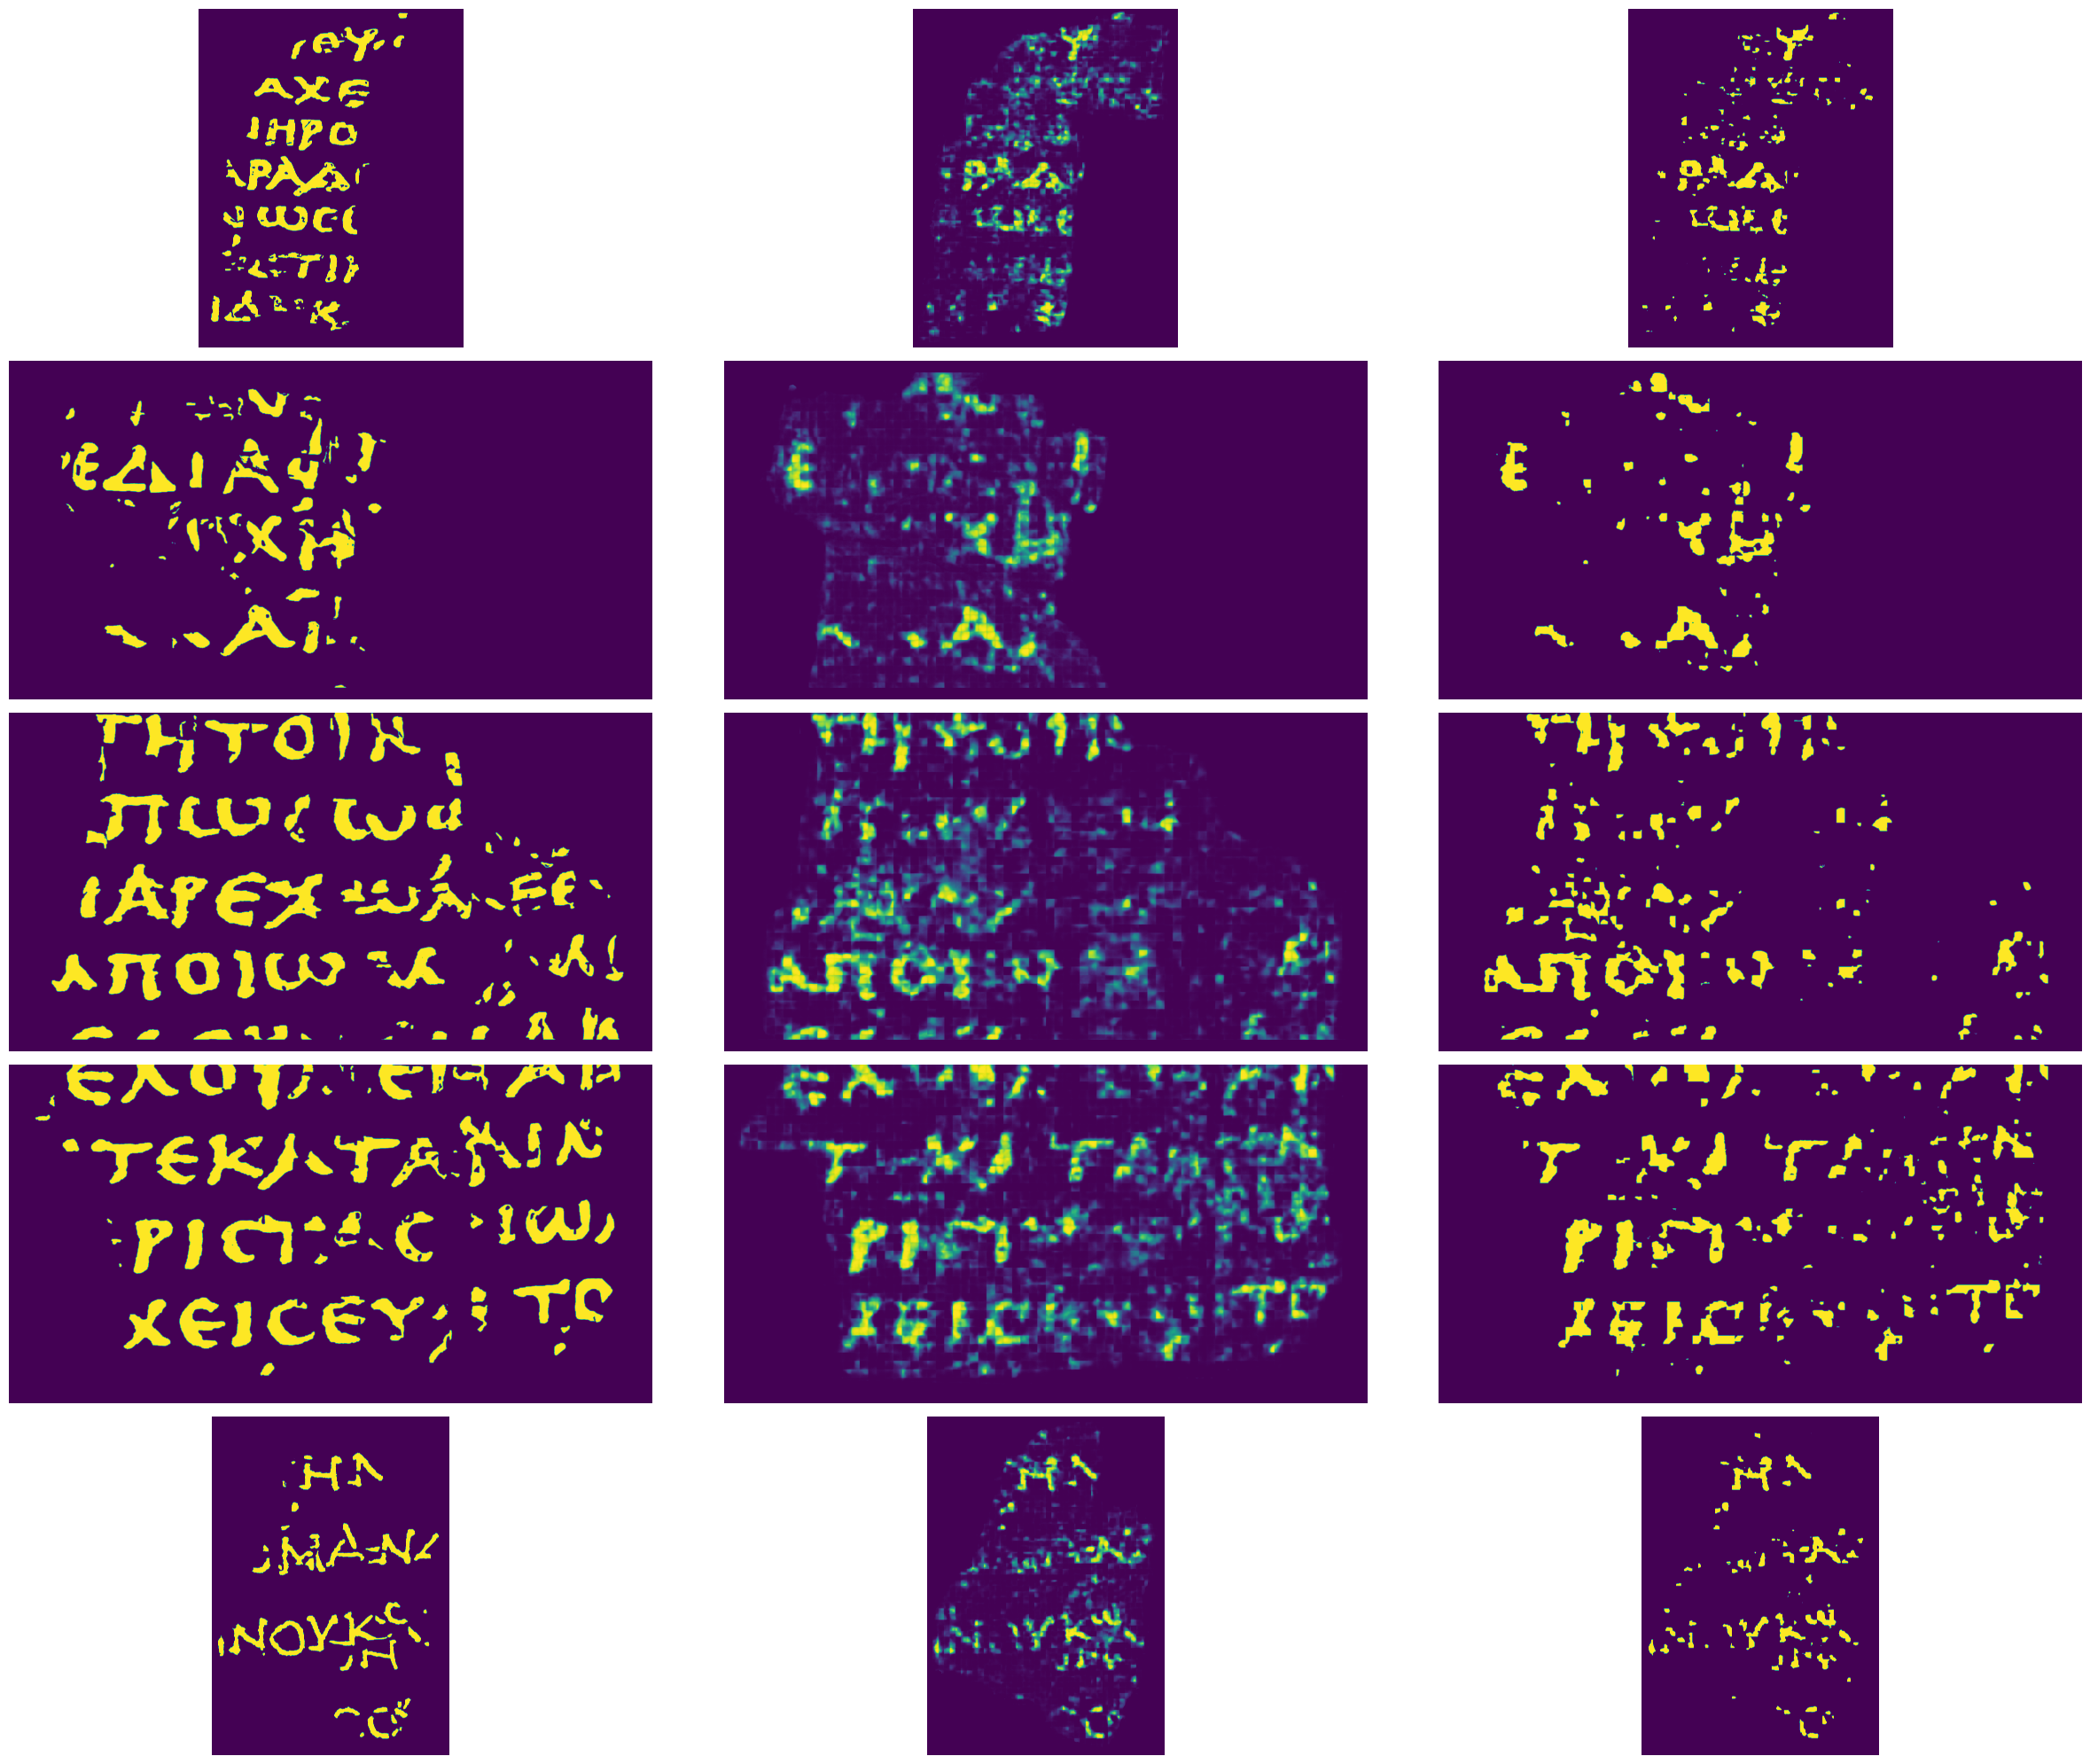

In [10]:
plot_inference(valid_label_gt_list, label_pred_list, CFG)